In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras import backend as K
import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
#from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
tf.keras.backend.set_floatx('float64')

2022-03-28 03:53:28.113358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [11]:
theta=np.linspace(0, 2*np.pi, num=200)
eta=[2*i*np.pi/3 for i in range(3)]
r0=0.8
r1=0.1

X=[]
for e in eta:
    x0=r0*np.cos(e)
    y0=r0*np.sin(e)
    print(x0,y0)
    for t in theta:
        X.append([x0+r1*np.cos(t),y0+r1*np.sin(t)])
X=np.array(X)

0.8 0.0
-0.39999999999999986 0.692820323027551
-0.40000000000000036 -0.6928203230275507


(-1.0, 1.0, -1.0, 1.0)

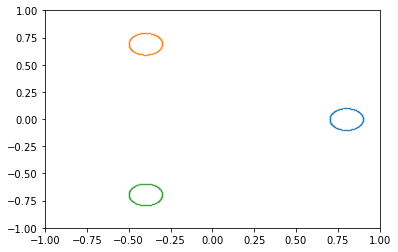

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:200,0],X[:200,1],s=.1)
plt.scatter(X[200:400,0],X[200:400,1],s=.1)
plt.scatter(X[400:600,0],X[400:600,1],s=.1)
plt.axis([-1,1,-1,1])

In [4]:
np.random.shuffle(X)

(-1.0, 1.0, -1.0, 1.0)

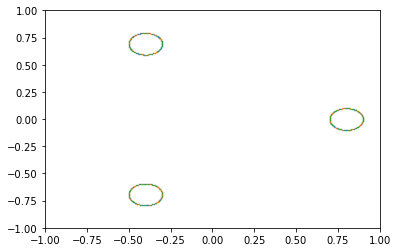

In [5]:
plt.scatter(X[:200,0],X[:200,1],s=.1)
plt.scatter(X[200:400,0],X[200:400,1],s=.1)
plt.scatter(X[400:600,0],X[400:600,1],s=.1)
plt.axis([-1,1,-1,1])

In [75]:
input=tf.keras.layers.Input(shape=(2,),dtype=tf.float64)
encoded=tf.keras.layers.Dense(9,activation='tanh',dtype=tf.float64)(input)
encoded=tf.keras.layers.Dense(2,activation='tanh',dtype=tf.float64)(encoded)
decoded=tf.keras.layers.Dense(9,activation='tanh',dtype=tf.float64)(encoded)
output=tf.keras.layers.Dense(2,activation='tanh',dtype=tf.float64)(decoded)
model=tf.keras.models.Model(input,output)
model.compile(optimizer="Adam", loss="mse")
enc=tf.keras.models.Model(input,encoded)
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 27        
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 20        
_________________________________________________________________
dense_30 (Dense)             (None, 9)                 27        
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 20        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [88]:
history=model.fit(X,X,epochs=2000,verbose=0)

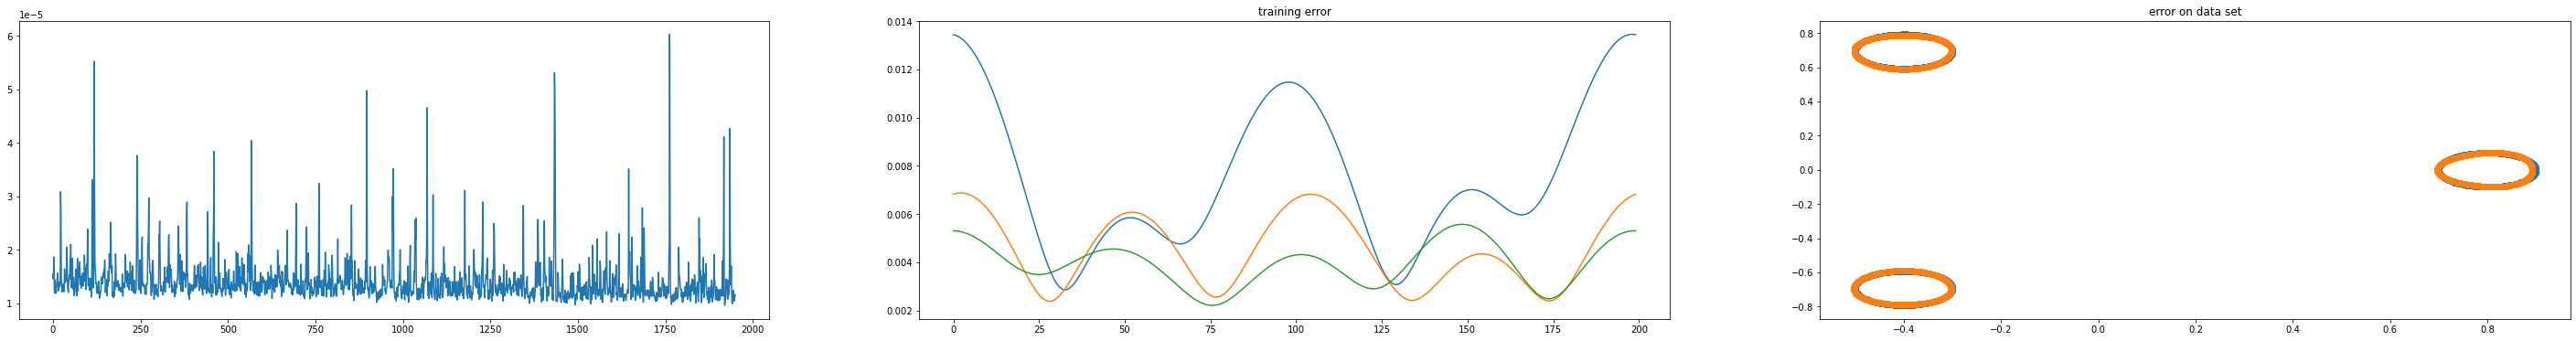

In [89]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(50, 6))

ax0.plot(range(len(history.history['loss'])-50),history.history['loss'][50:])
ax1.set_title('training error')
for i in range(3):
    ax1.plot(range(200),np.linalg.norm(X[i*200:(i+1)*200,:]-Y[i*200:(i+1)*200,:],axis=1))

ax2.set_title('error on data set')
Y=model.predict(X)
ax2.scatter(X[:,0],X[:,1])
ax2.scatter(Y[:,0],Y[:,1])

In [ ]:
w=[]
for i in range(1,5):
    W,b=model.layers[i].get_weights()
    w.append({'W':W,'b':b})

In [ ]:
w

In [ ]:
np.linalg.eig(w[1]['W'].dot(w[1]['W'].transpose()))

In [ ]:
np.linalg.eig(w[1]['W'].transpose().dot(w[1]['W']))